# Imports

In [20]:
import numpy   as np
import pandas  as pd

from typing import List, Dict

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [2]:
from dstoolkit.lightgbm.classifier import AutoMLLGBMClassifier, AutoMLLGBMClassifierCV
from dstoolkit.lightgbm.regressor import AutoMLLGBMRegressor, AutoMLLGBMRegressorCV

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regressor

In [3]:
df = pd.read_csv('../data/monthly.csv', )
df['time'] = pd.to_datetime(df['Year'])
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

import warnings

import numpy  as np
import pandas as pd

from typing import List, Dict

from scipy.stats import skew, kurtosis


class SimpleLagTimeFeatureCreator:
    
    def __init__(self, windows: List[int] = [2, 3, 4], functions: List[str] = ["mean", "median", "max", "min"]):
        
        """
        Initiate the lag feature creator.
        
        Args:
            windows: List of window sizes for calculating statistics
            functions: List of functions to be applied (mean, median, max, min, etc.)

        Raises:
            UserWarning: If the list of windows contains the value 1
        """
        
        self.windows = windows
        self.functions = functions
        
        self._function_map = {
            'mean': np.mean,
            'median': np.median,
            'max': np.max,
            'min': np.min,
            'sum': np.sum,
            'std': lambda x: np.std(x, ddof=1),
            'diff': np.ptp,
            'kurt': lambda x: kurtosis(x, bias=False),
            'skew': lambda x: skew(x, bias=False),
            'slope': self._calc_slope
        }

        if 1 in self.windows:
            warnings.warn(
                "Window size 1 was found. Windows with size equal to 1 are not recommended for lag/rolling calculations, because they do not aggregate temporal information.",
                UserWarning
            )
            self.windows.remove(1)
    
    def _calc_slope(self, x: np.ndarray) -> float:
        
        """Calculates the slope using least squares."""
        
        return np.polyfit(np.arange(len(x)), x, 1)[0]

    def _create_lag_features(self, series: pd.Series) -> Dict[str, pd.Series]:
        
        """Creates all lagged features for a time series."""
        
        lag_one = series.shift(1)
        features = {f'{series.name}_sum_1_lag': lag_one}
        
        valid_funcs = [func for func in self.functions if func in self._function_map]
        
        for func in valid_funcs:
            
            func_operation = self._function_map[func]
            
            for win in self.windows:
                
                feature_values = lag_one.rolling(window=win, min_periods=2).apply(func_operation, raw=True)
                features[f'{series.name}_{func}_{win}_lag'] = feature_values
        
        return features
    
    def calculate(self, df: pd.DataFrame, target: str, time: str) -> pd.DataFrame:
        
        """
        Calculates all features with temporal lag for the target column.
        
        Args:
            df: Input DataFrame
            target: Name of the target column for feature calculation
            time: Name of the column with temporal data
            
        Returns:
            DataFrame with the new features added
        """
        
        if target not in df.columns:
            raise ValueError(f"Coluna '{target}' não encontrada no DataFrame")
            
        df = df.sort_values(by=time)
        
        features = self._create_lag_features(df[target])
        
        return df.assign(**features)

s = SimpleLagTimeFeatureCreator([2, 3, 4, 5, 6], ["mean", "median", "max", "min", "std", "diff", "slope"])
df1 = s.calculate(df, target='temperature', time='time')

X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

best_features_reg = [
    'temperature_mean_4_lag',
    'temperature_mean_2_lag',
    'temperature_mean_6_lag',
    'temperature_max_2_lag',
    'temperature_sum_1_lag',
    'temperature_median_6_lag',
    'temperature_slope_3_lag',
    'temperature_min_6_lag',
    'temperature_min_4_lag',
    'temperature_max_6_lag',
    'temperature_slope_5_lag',
    'temperature_slope_2_lag',
    'temperature_slope_4_lag',
    'temperature_slope_6_lag',
    'temperature_std_6_lag',
    'temperature_std_2_lag',
    'temperature_median_3_lag',
    'temperature_min_3_lag']

In [4]:
a = AutoMLLGBMRegressor(
    X_train, y_train, 
    X_valid, y_valid,
    X_test, y_test,
    target='temperature',
    best_features=best_features_reg,
    n_trials=50,
    scoring='r2'
)

In [5]:
a.train()

In [6]:
a.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.981496  0.042409  0.033612  8.712993e+11  0.055445   
1   Valid  0.910518  0.090920  0.069620  8.179279e-01  0.119947   
2    Test  0.899448  0.093625  0.070357  4.191416e+12  0.125315   
3   Train  0.978107  0.046529  0.037398  9.035749e+11  0.060309   
4   Valid  0.912021  0.090714  0.071367  8.205065e-01  0.118935   
5    Test  0.901091  0.091610  0.066708  3.776065e+12  0.124287   
6   Train  0.940895  0.076445  0.060883  1.437390e+12  0.099093   
7   Valid  0.918592  0.087294  0.066292  7.990121e-01  0.114408   
8    Test  0.908300  0.089308  0.068113  4.112829e+12  0.119672   

   Explained Variance               Model  
0            0.981496          Base Model  
1            0.910860          Base Model  
2            0.899700          Base Model  
3            0.978107  Best Feature Model  
4            0.912266  Best Feature Model  
5            0.901323  Best Feature Model  
6            0.940895   Best Params Model  
7            0.918853   Best Params Model  
8            0.908602   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.981496  0.042409  0.033612  8.712993e+11  0.055445   
1   Valid  0.910518  0.090920  0.069620  8.179279e-01  0.119947   
2    Test  0.899448  0.093625  0.070357  4.191416e+12  0.125315   

   Explained Variance  
0            0.981496  
1            0.910860  
2            0.899700

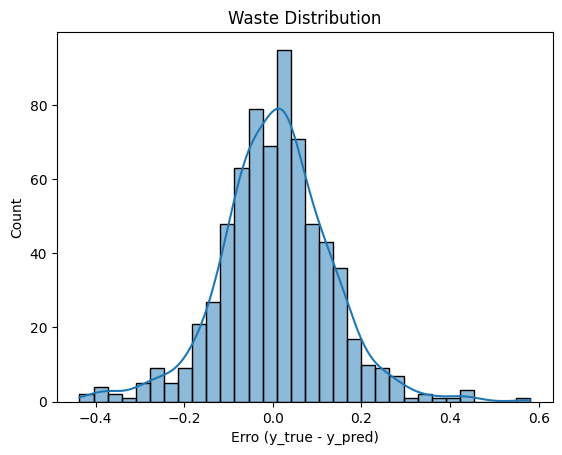

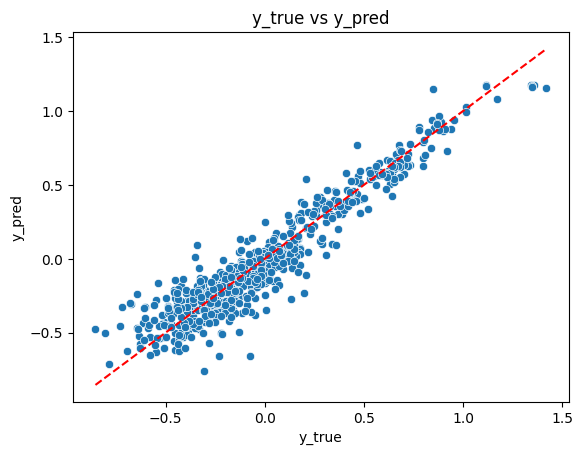

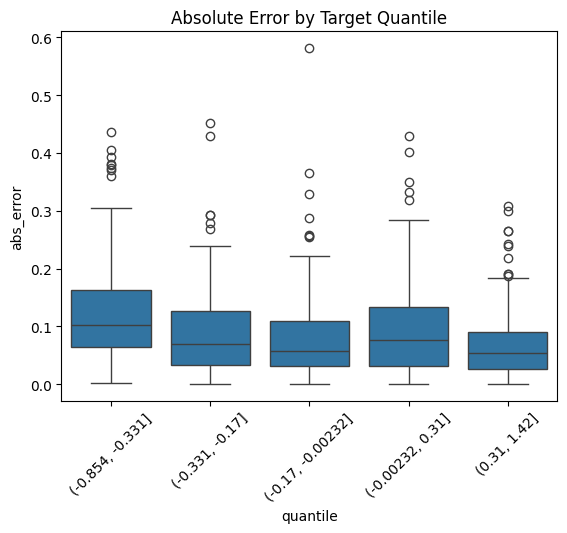

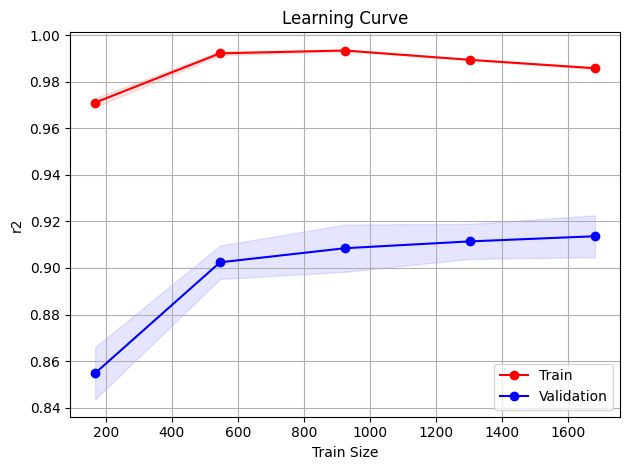

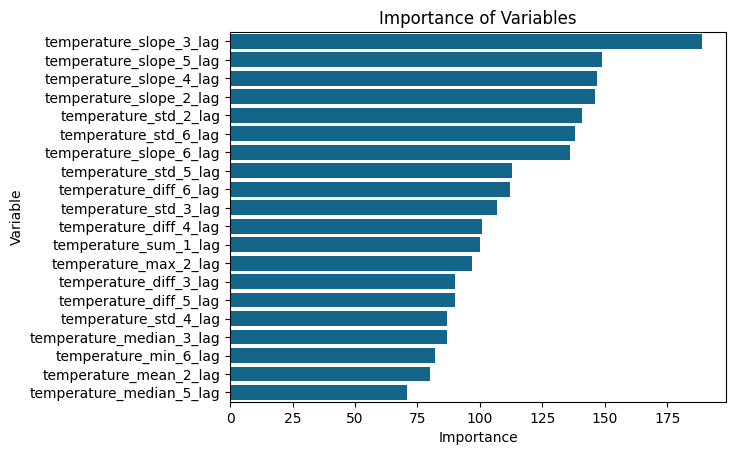

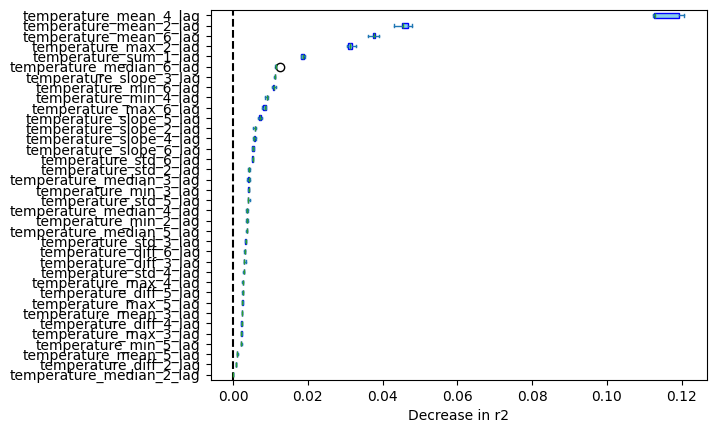

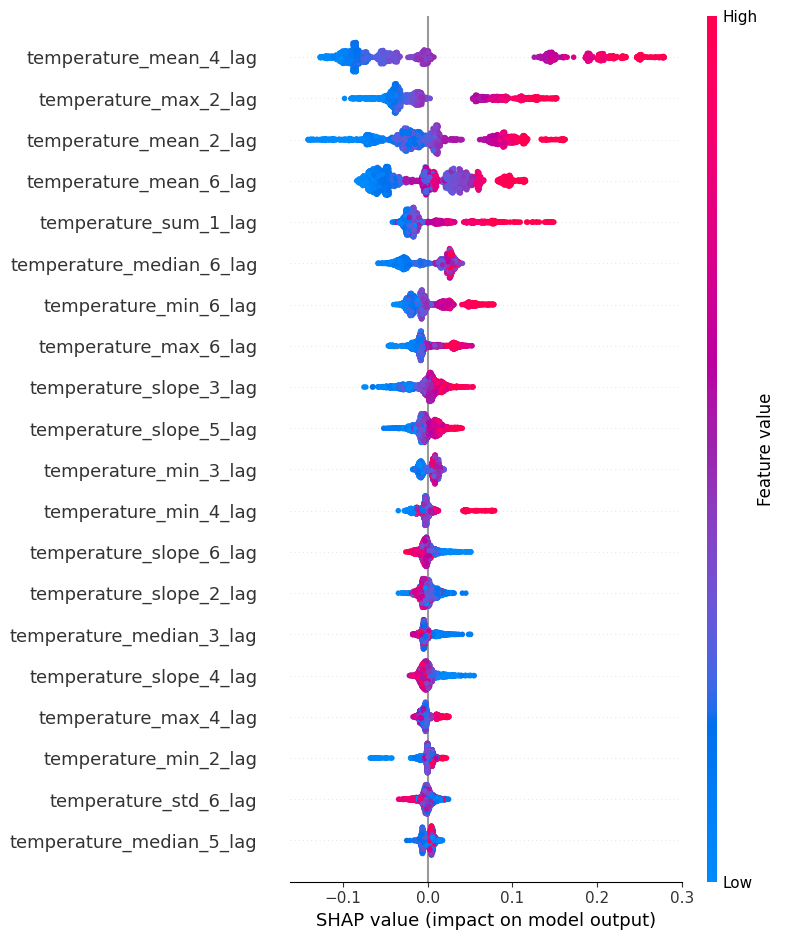

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.978107  0.046529  0.037398  9.035749e+11  0.060309   
1   Valid  0.912021  0.090714  0.071367  8.205065e-01  0.118935   
2    Test  0.901091  0.091610  0.066708  3.776065e+12  0.124287   

   Explained Variance  
0            0.978107  
1            0.912266  
2            0.901323

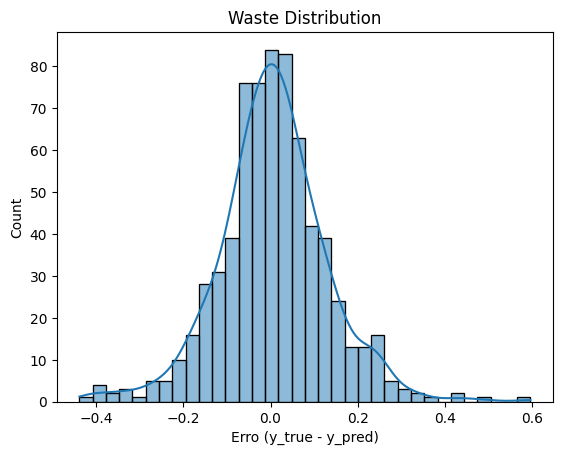

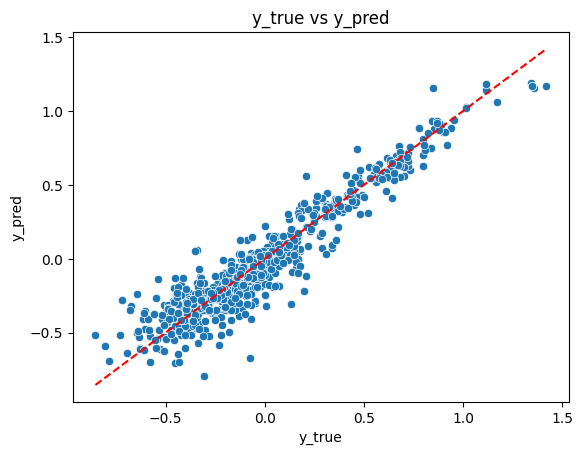

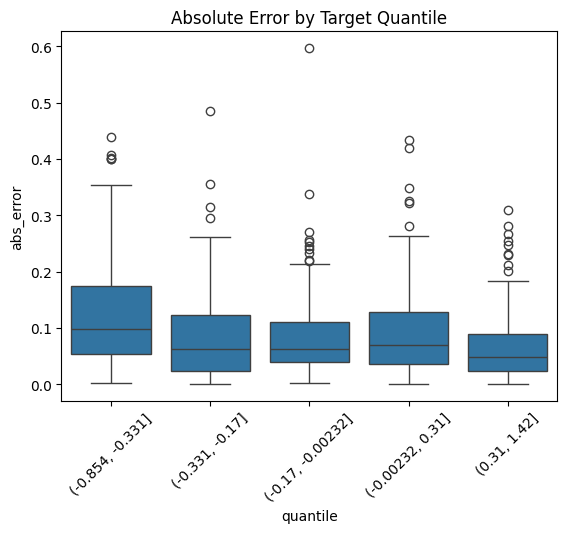

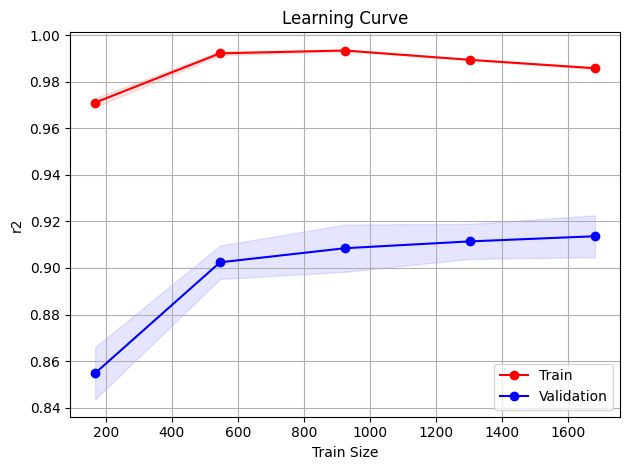

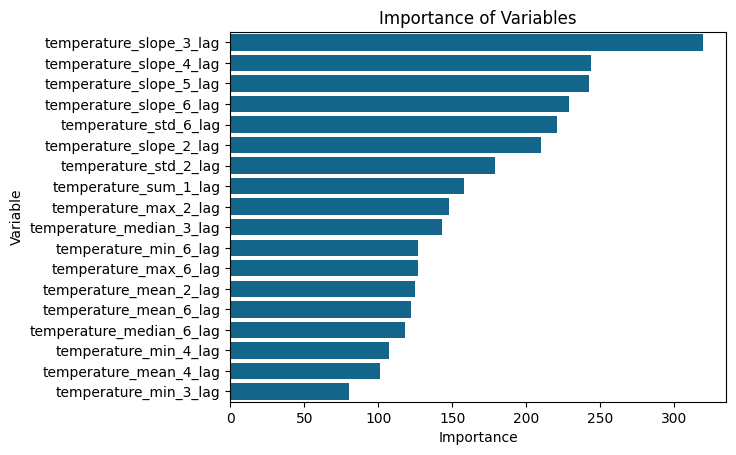

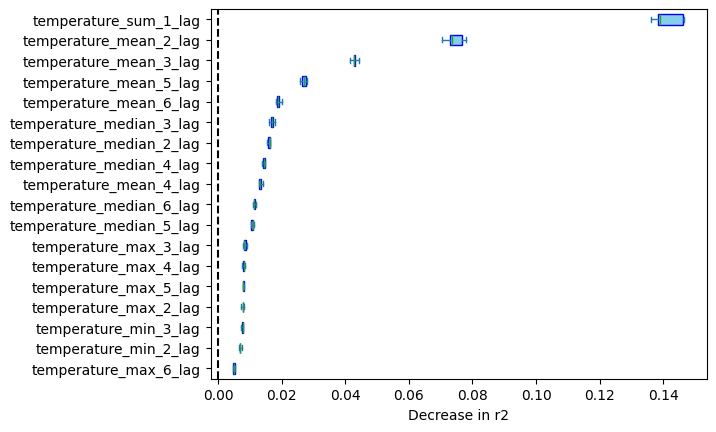

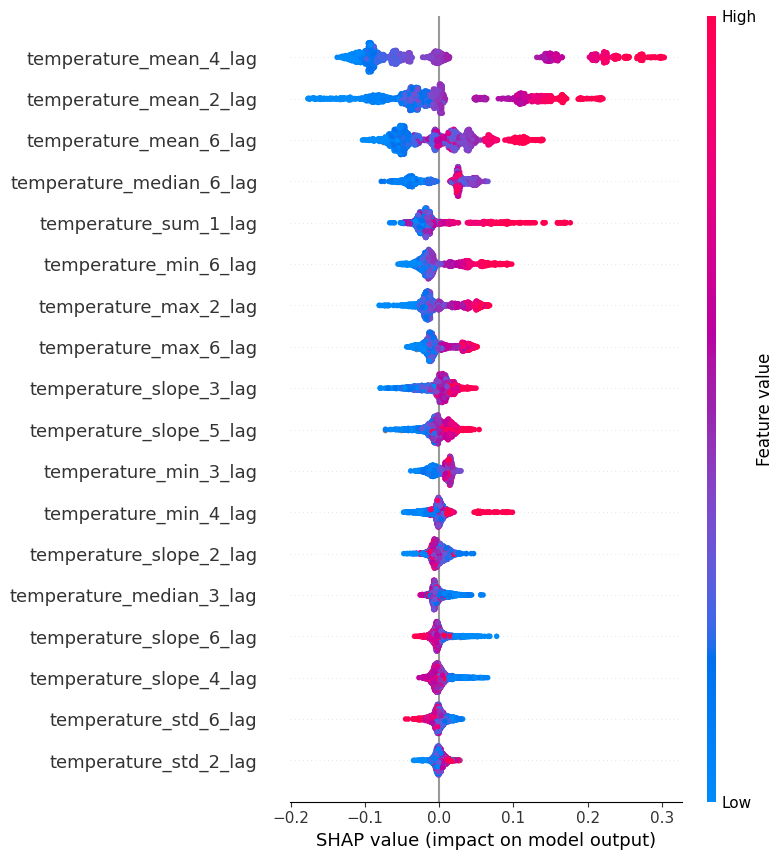

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.940895  0.076445  0.060883  1.437390e+12  0.099093   
1   Valid  0.918592  0.087294  0.066292  7.990121e-01  0.114408   
2    Test  0.908300  0.089308  0.068113  4.112829e+12  0.119672   

   Explained Variance  
0            0.940895  
1            0.918853  
2            0.908602

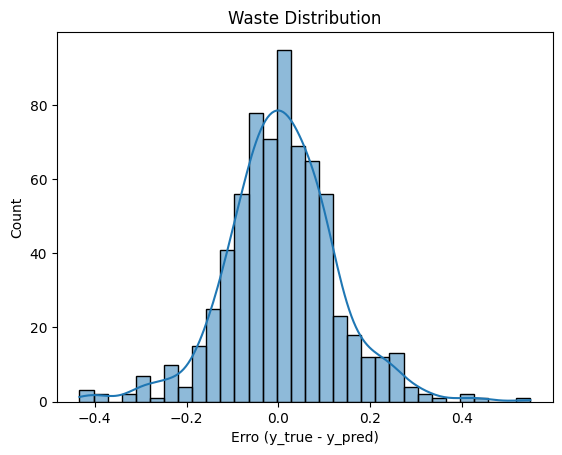

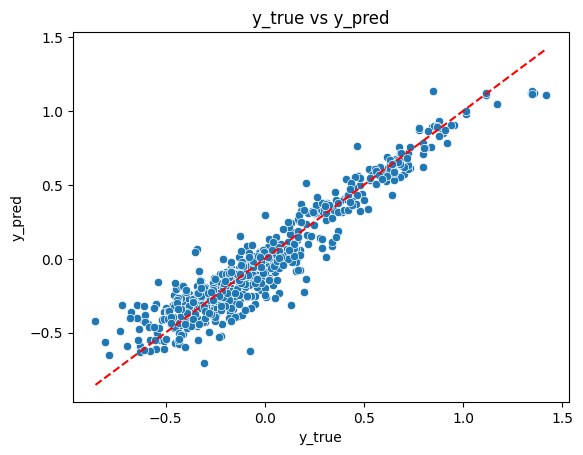

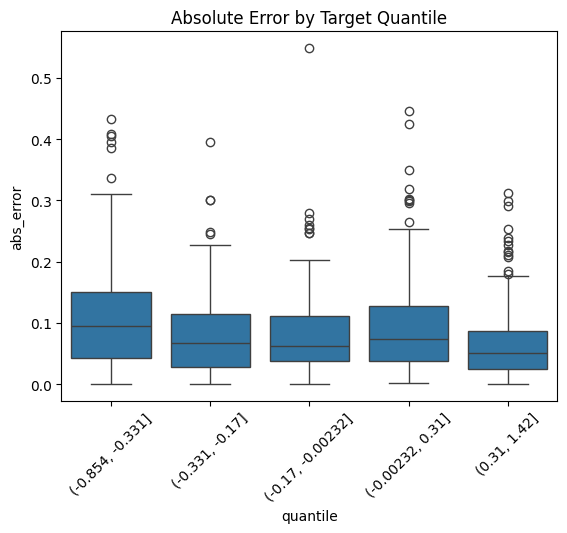

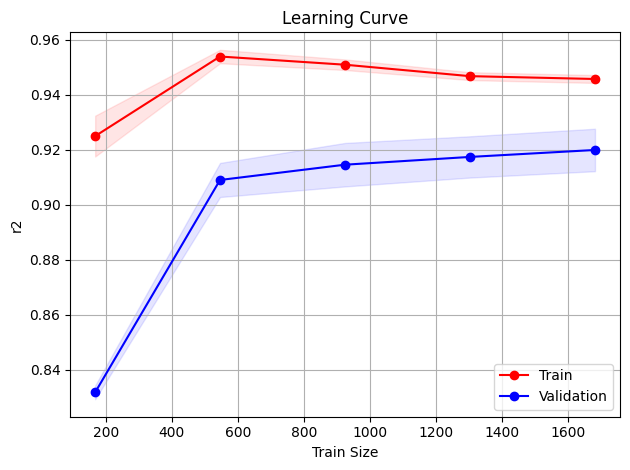

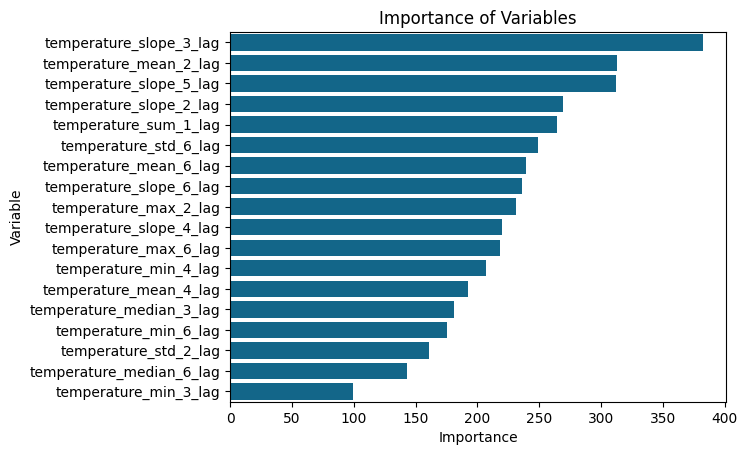

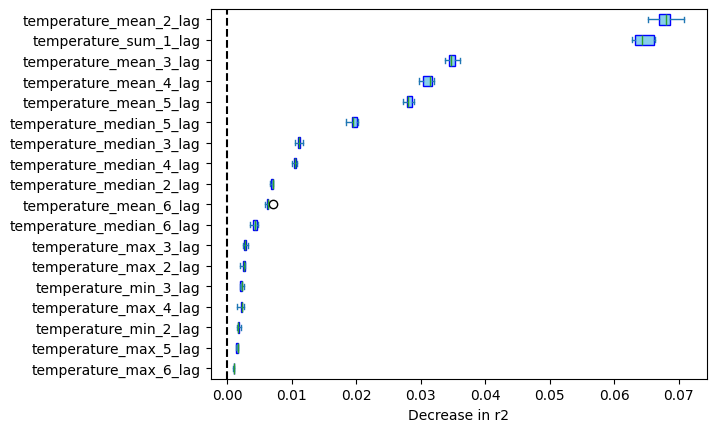

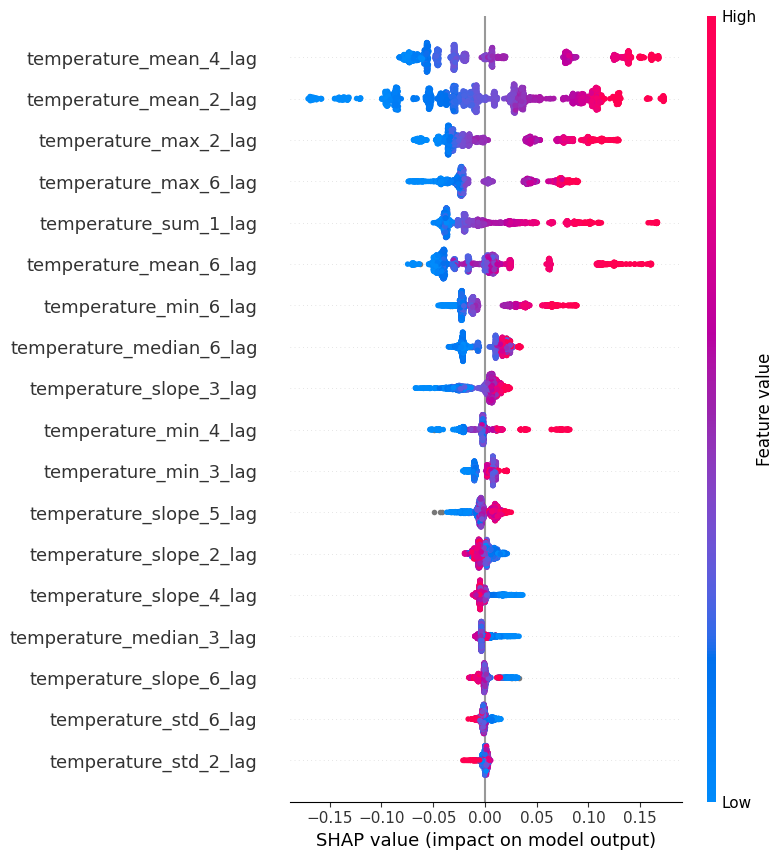

In [7]:
a.get_result_analysis()

In [8]:
acv = AutoMLLGBMRegressorCV(
    X_train, y_train, 
    X_test, y_test,
    target='temperature',
    cv=KFold(shuffle=True, random_state=42),
    best_features=best_features_reg,
    n_trials=50,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

In [9]:
acv.train()

In [10]:
acv.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.914242  0.091087  0.072127  1.755845e+12  0.119127   
1      Test  0.899448  0.093625  0.070357  4.191416e+12  0.125315   
2  Train CV  0.913867  0.090860  0.071902  1.846373e+12  0.119418   
3      Test  0.901091  0.091610  0.066708  3.776065e+12  0.124287   
4  Train CV  0.920019  0.088791  0.071618  1.693934e+12  0.115081   
5      Test  0.904860  0.091155  0.069200  4.346365e+12  0.121896   

   Explained Variance               Model  
0            0.914484          Base Model  
1            0.899700          Base Model  
2            0.914115  Best Feature Model  
3            0.901323  Best Feature Model  
4            0.920232   Best Params Model  
5            0.905165   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.914242  0.091087  0.072127  1.755845e+12  0.119127   
1      Test  0.899448  0.093625  0.070357  4.191416e+12  0.125315   

   Explained Variance  
0            0.914484  
1            0.899700

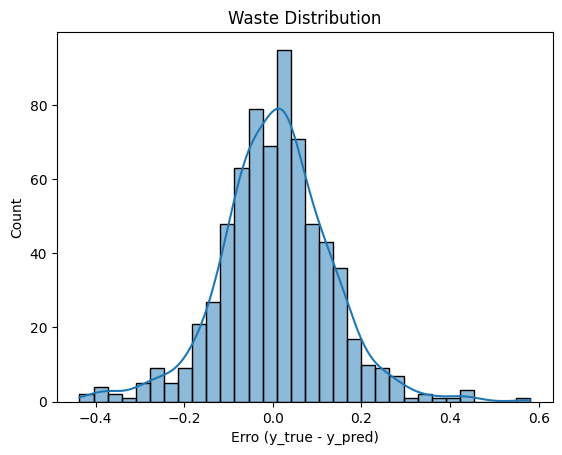

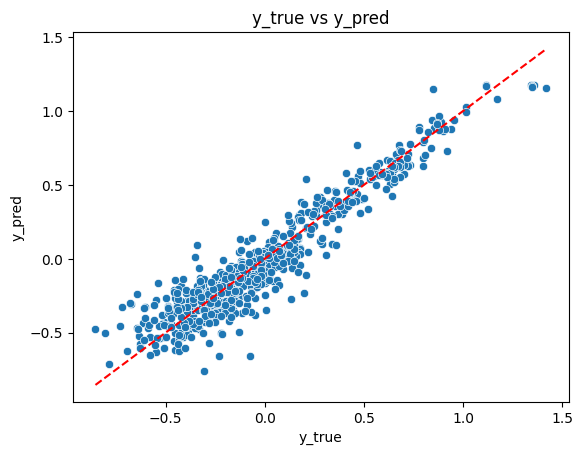

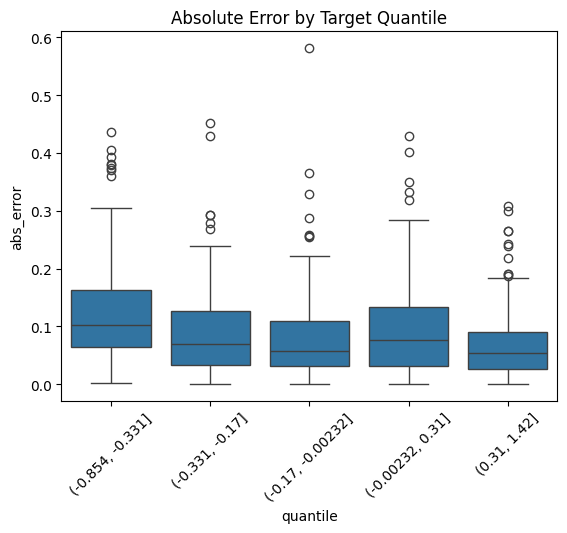

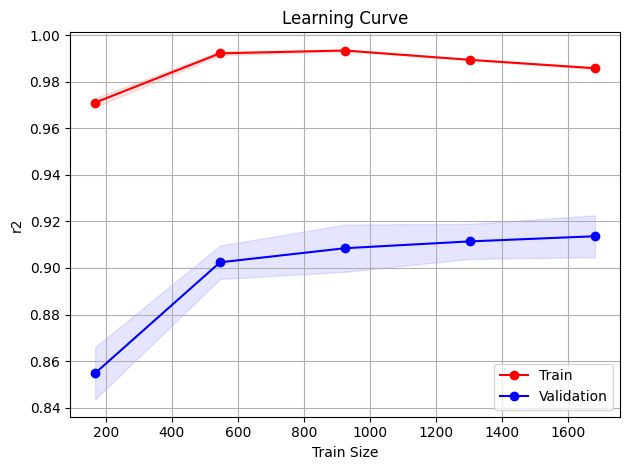

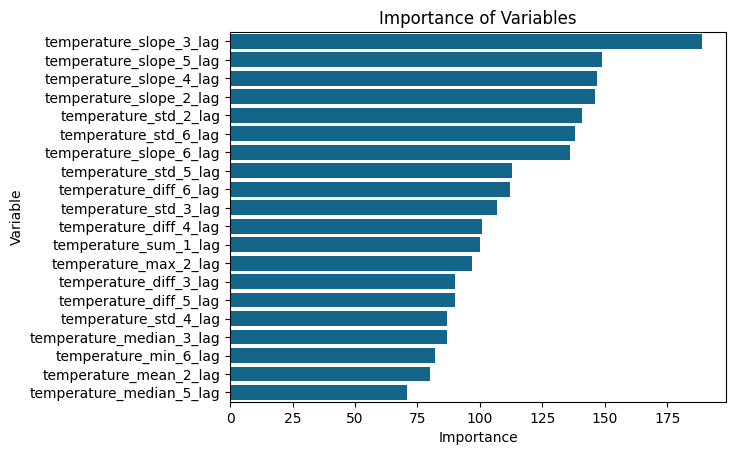

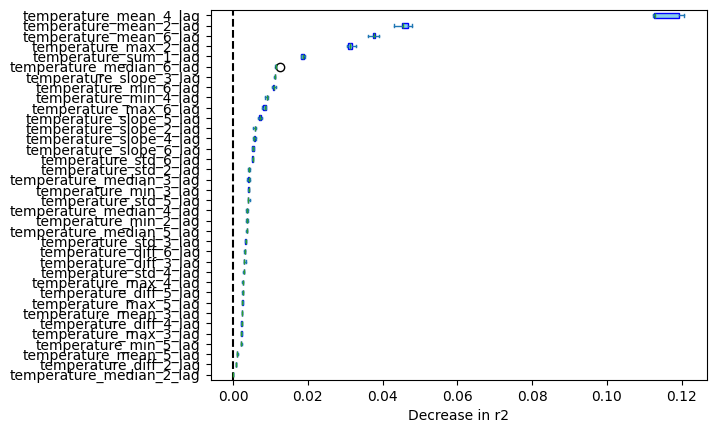

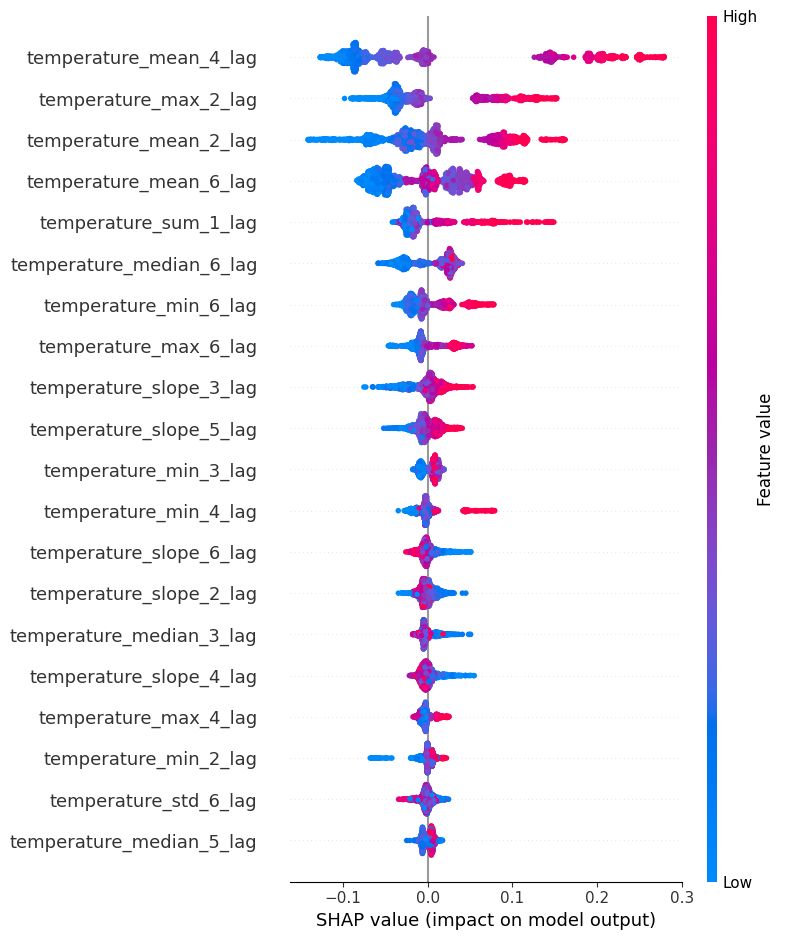

best_feature_model Results


Dataset        R2      MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.913867  0.09086  0.071902  1.846373e+12  0.119418   
1      Test  0.901091  0.09161  0.066708  3.776065e+12  0.124287   

   Explained Variance  
0            0.914115  
1            0.901323

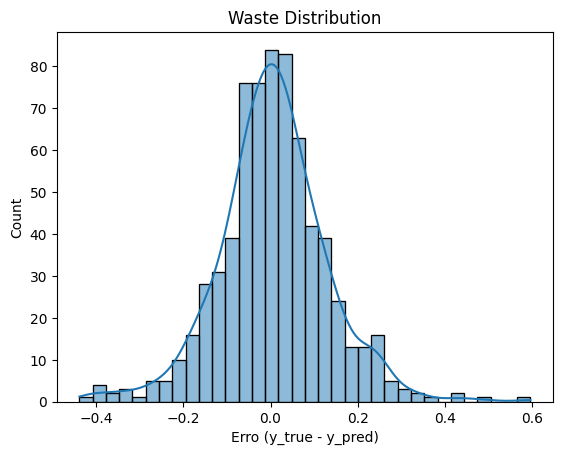

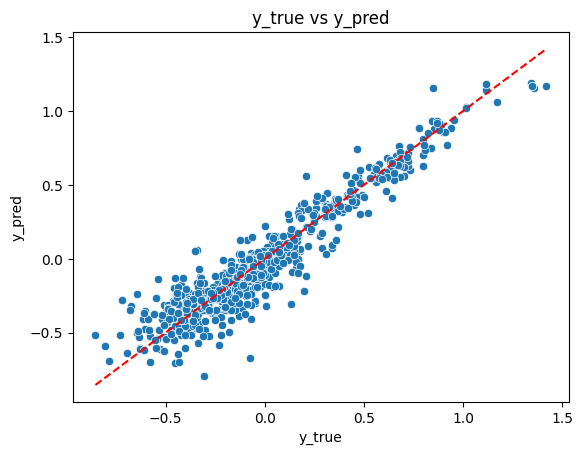

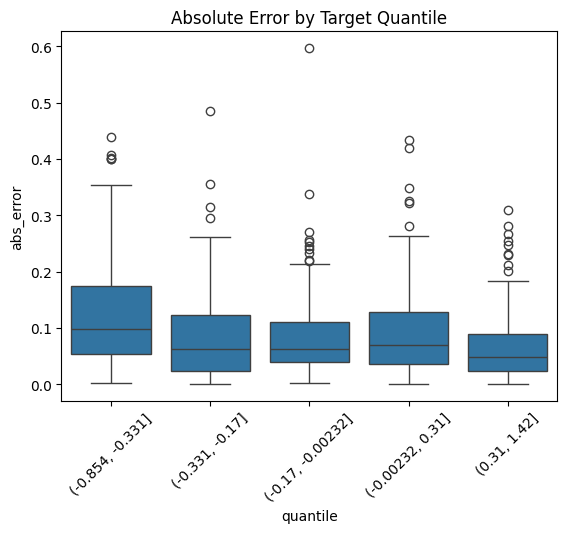

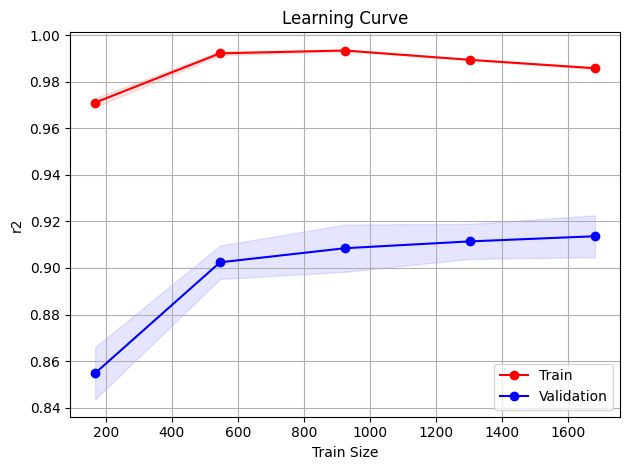

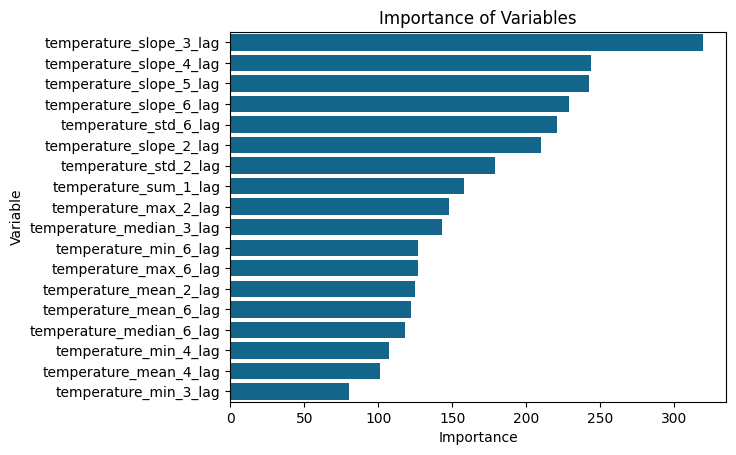

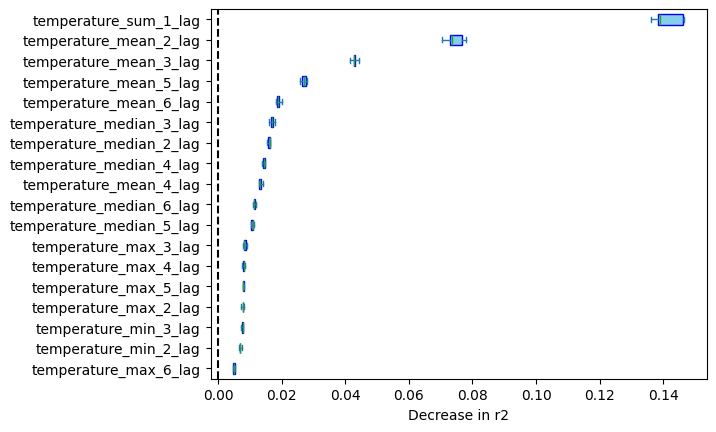

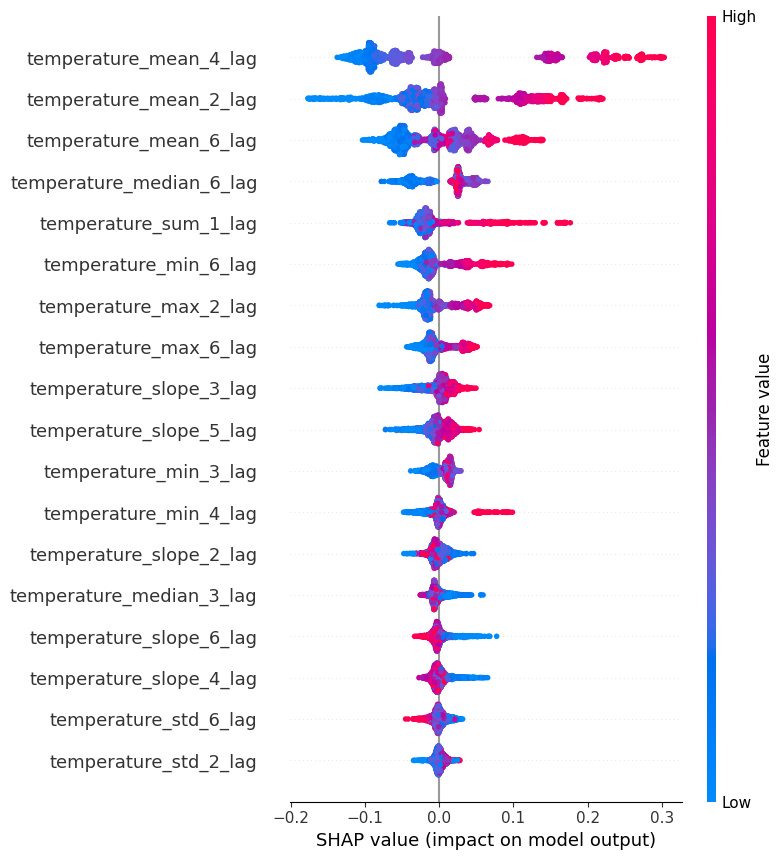

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.920019  0.088791  0.071618  1.693934e+12  0.115081   
1      Test  0.904860  0.091155  0.069200  4.346365e+12  0.121896   

   Explained Variance  
0            0.920232  
1            0.905165

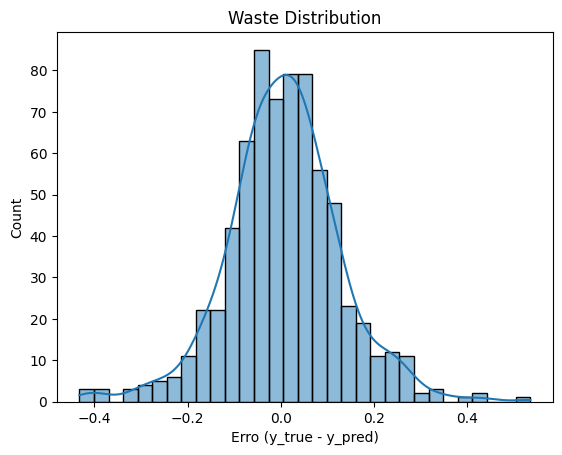

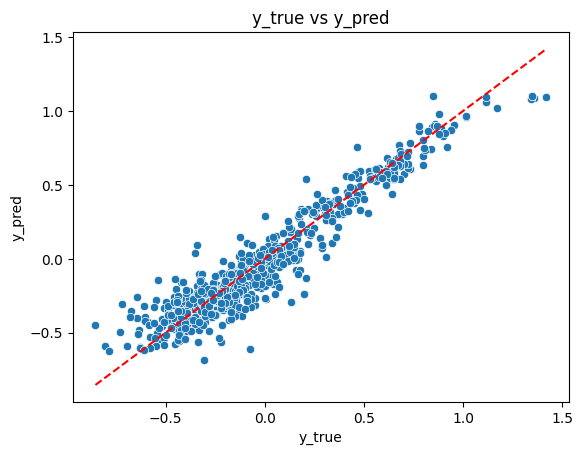

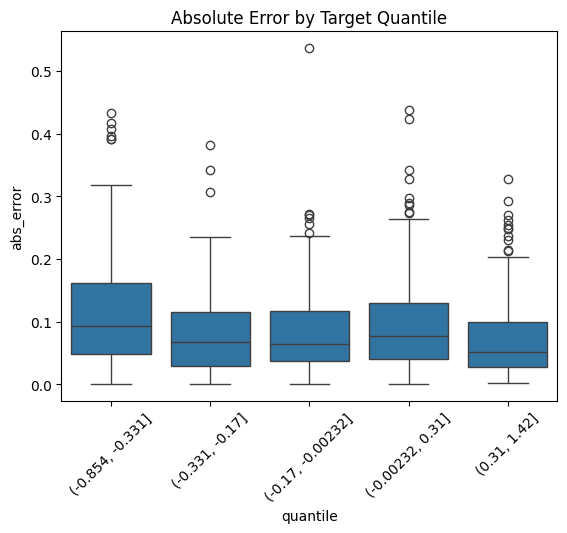

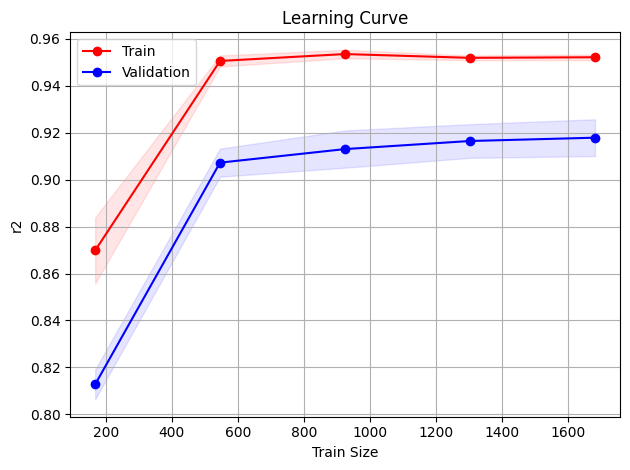

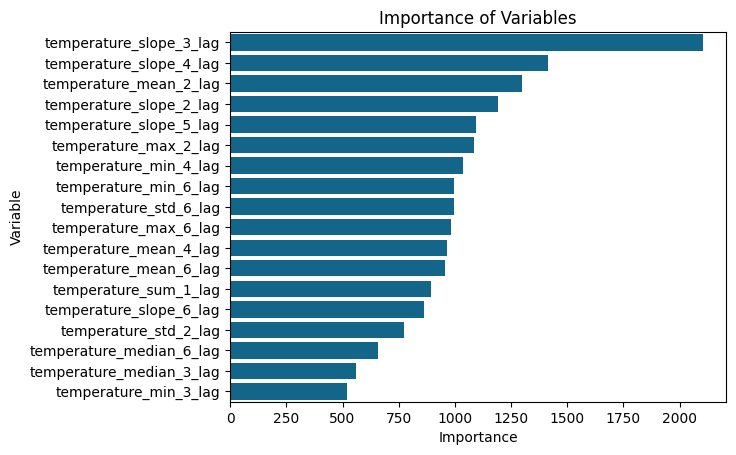

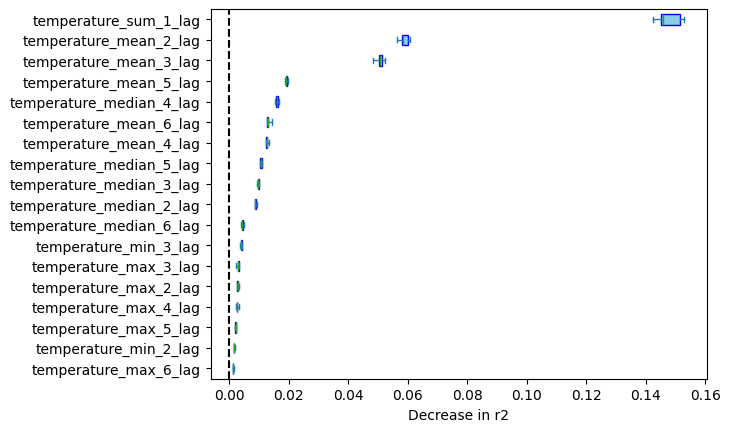

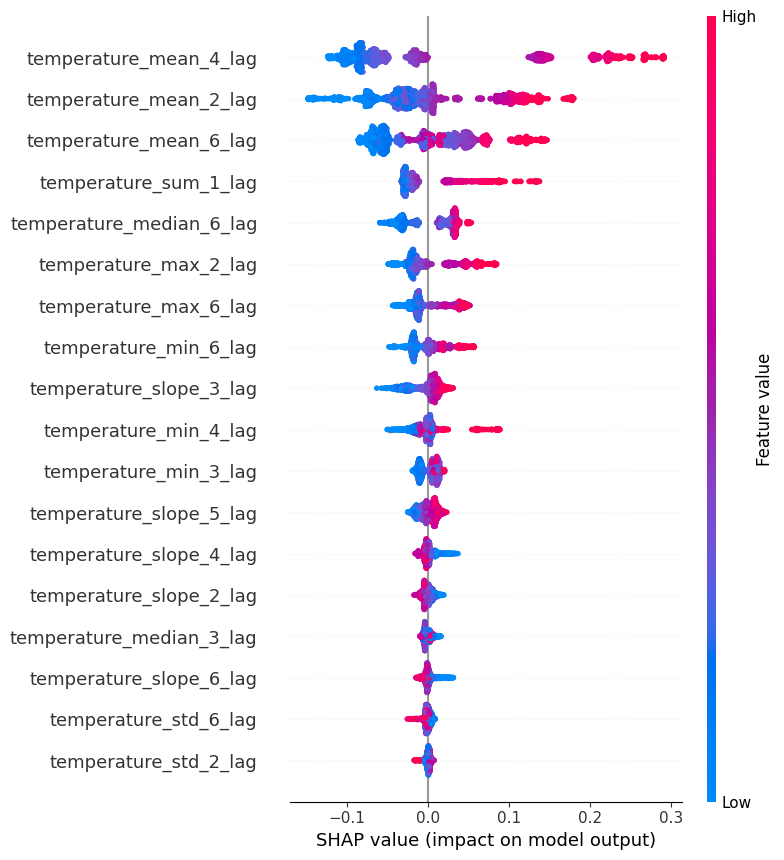

In [11]:
acv.get_result_analysis()

# Classifier

In [14]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df[['SeriousDlqin2yrs']].rename({'SeriousDlqin2yrs': 'target'}, axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y['target'])
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42, stratify=y_temp['target'])

best_features_class = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'age', 'DebtRatio', 'MonthlyIncome']

In [15]:
a = AutoMLLGBMClassifier(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    scoring='roc_auc',
    n_jobs=-1
)

In [16]:
a.train()

In [17]:
a.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   
3   Train  0.216080           0.730571   0.445322  0.506316  0.473864   
4   Valid  0.226131           0.708750   0.429733  0.461347  0.444979   
5    Test  0.206030           0.704950   0.378749  0.464464  0.417250   
6   Train  0.216080           0.713130   0.432854  0.470412  0.450852   
7   Valid  0.195980           0.721937   0.411196  0.494597  0.449057   
8    Test  0.165829           0.728224   0.359931  0.523067  0.426429   

        AUC        KS     Brier               Model  
0  0.902256  0.644746  0.044558          Base Model  
1  0.867222  0.579020  0.048628          Base Model  
2  0.859473  0.557068  0.049605          Base Model  
3  0.892142  0.618199  0.046208  Best Feature Model  
4  0.856926  0.564522  0.049246  Best Feature Model  
5  0.850480  0.543173  0.050418  Best Feature Model  
6  0.872006  0.584187  0.047979   Best Params Model  
7  0.860310  0.568338  0.049159   Best Params Model  
8  0.853382  0.549855  0.050099   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.902256  0.644746  0.044558  
1  0.867222  0.579020  0.048628  
2  0.859473  0.557068  0.049605

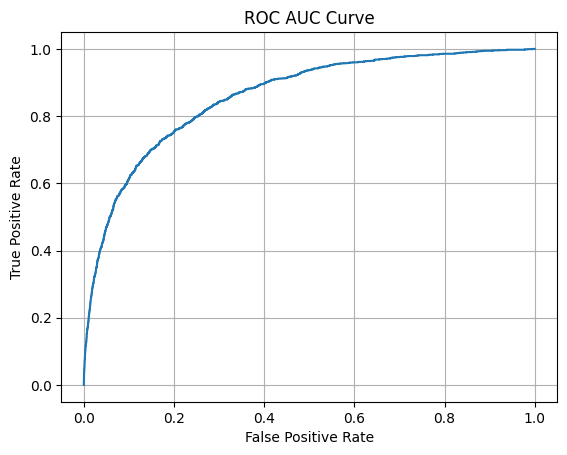

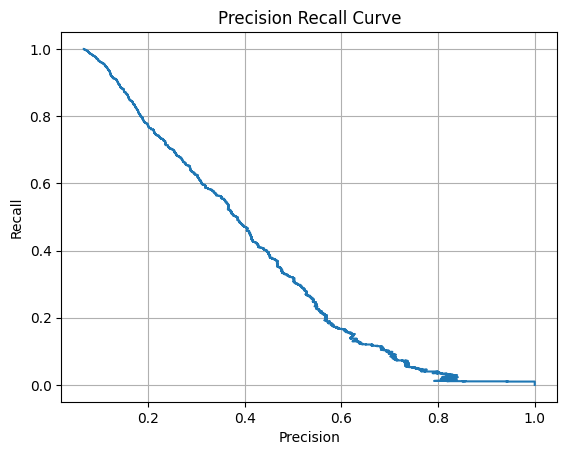

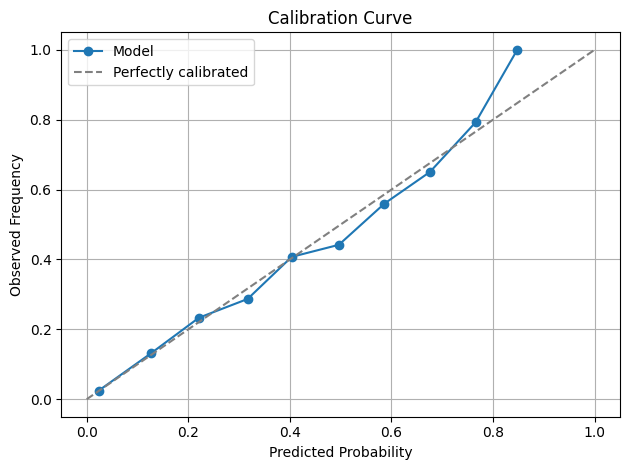

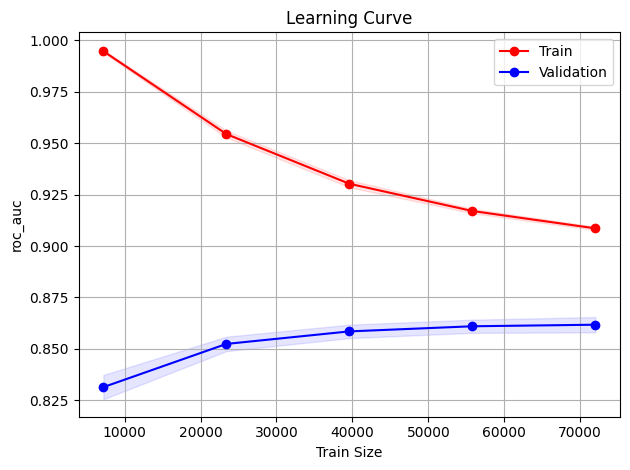

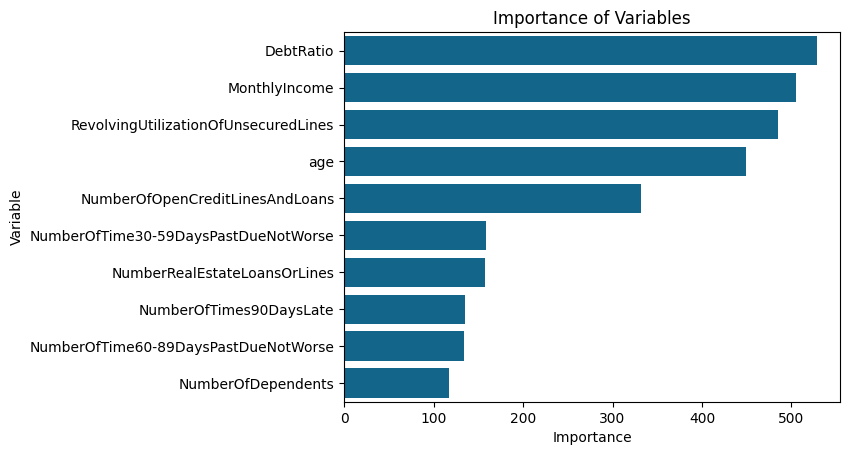

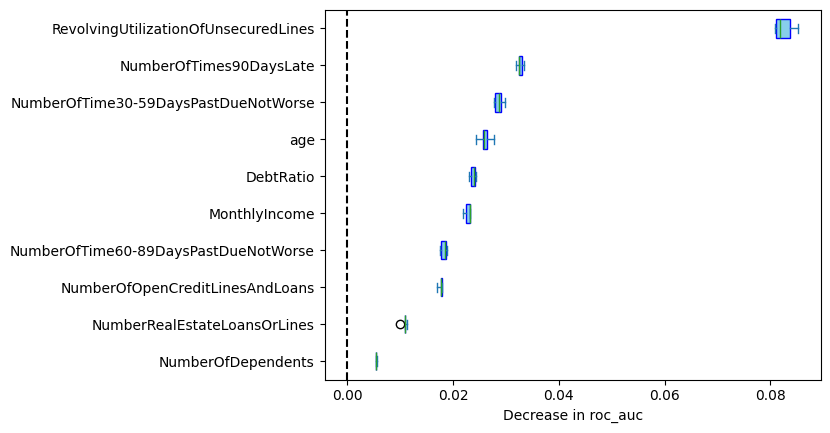

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


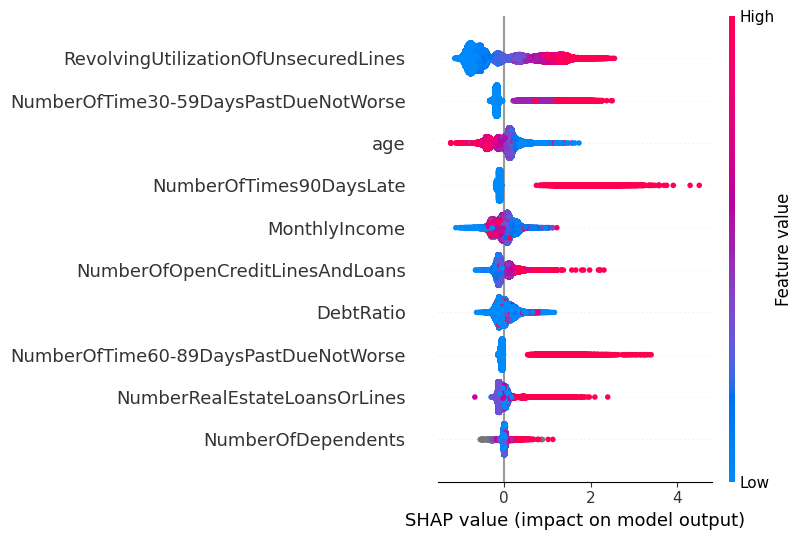

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.216080           0.730571   0.445322  0.506316  0.473864   
1   Valid  0.226131           0.708750   0.429733  0.461347  0.444979   
2    Test  0.206030           0.704950   0.378749  0.464464  0.417250   

        AUC        KS     Brier  
0  0.892142  0.618199  0.046208  
1  0.856926  0.564522  0.049246  
2  0.850480  0.543173  0.050418

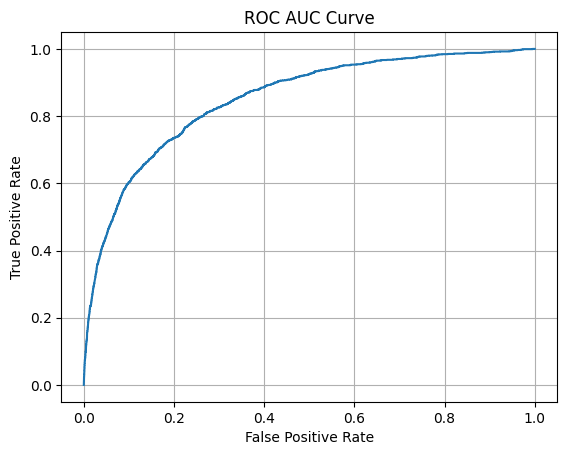

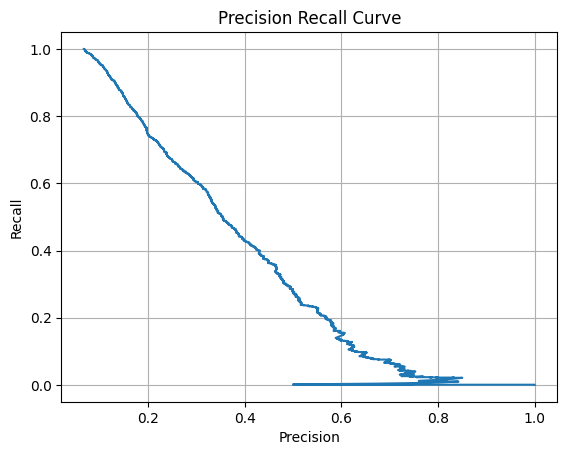

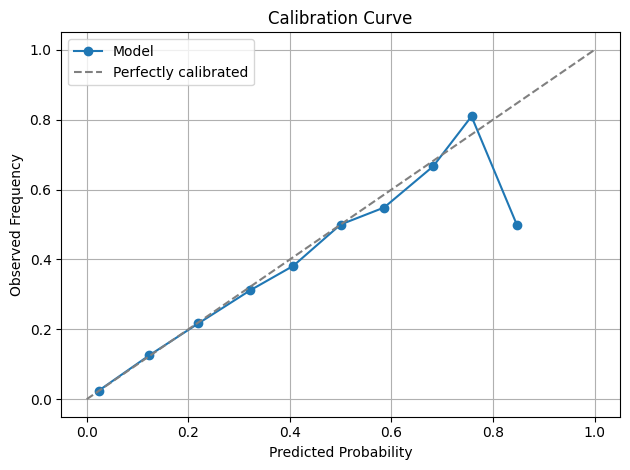

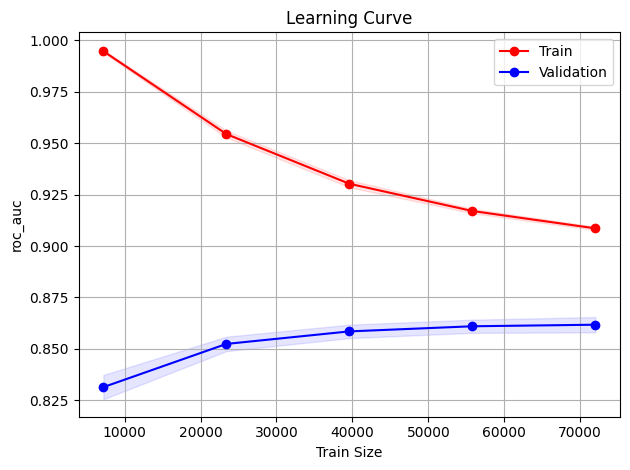

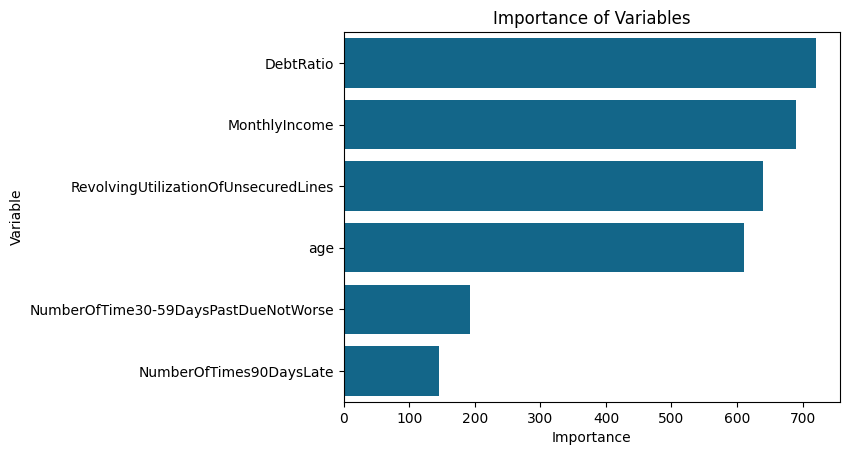

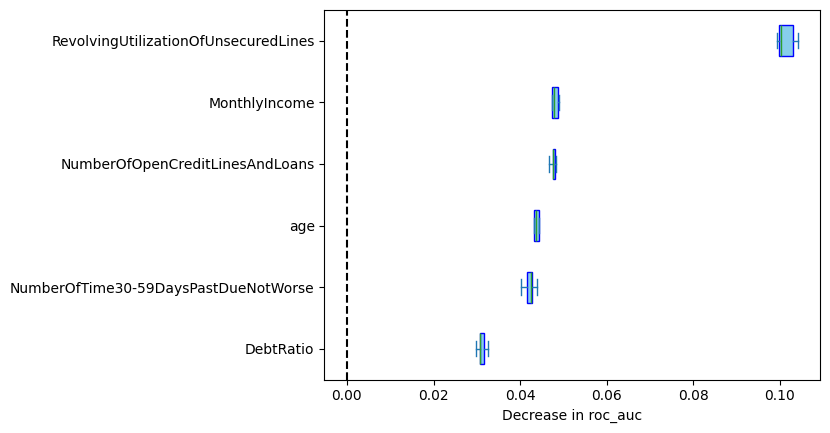

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


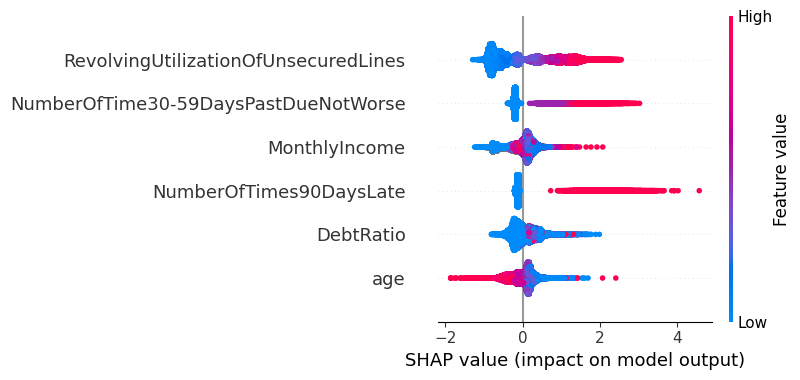

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.216080           0.713130   0.432854  0.470412  0.450852   
1   Valid  0.195980           0.721937   0.411196  0.494597  0.449057   
2    Test  0.165829           0.728224   0.359931  0.523067  0.426429   

        AUC        KS     Brier  
0  0.872006  0.584187  0.047979  
1  0.860310  0.568338  0.049159  
2  0.853382  0.549855  0.050099

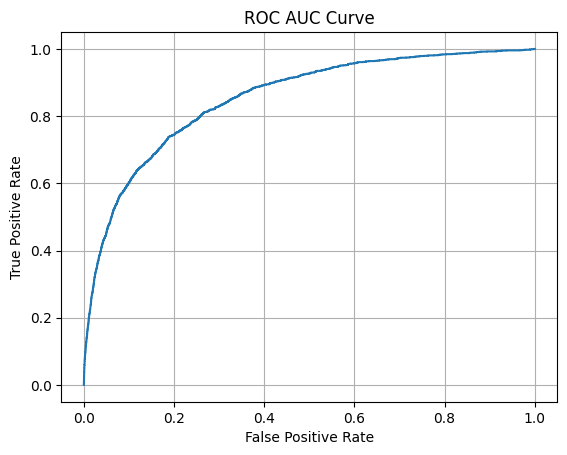

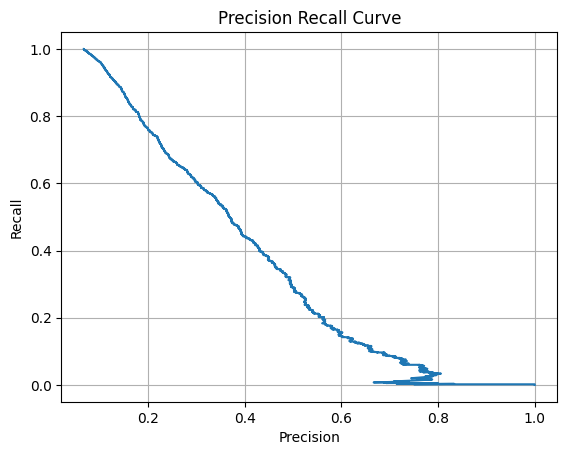

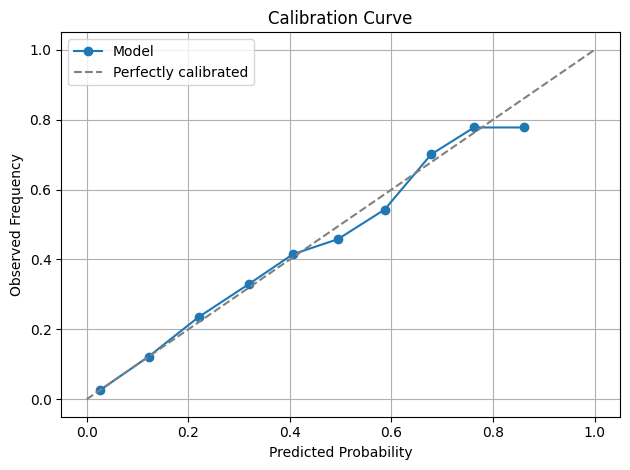

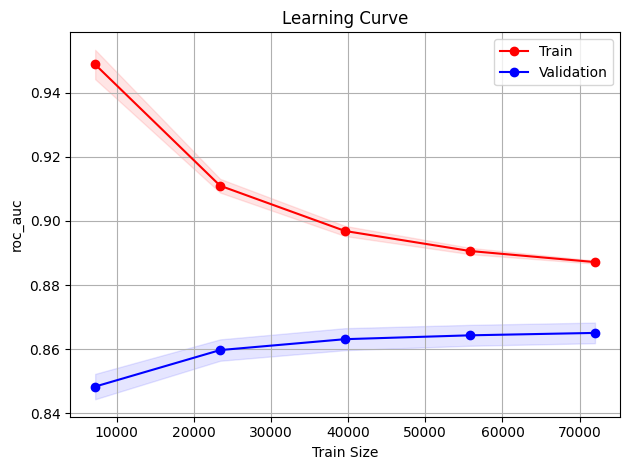

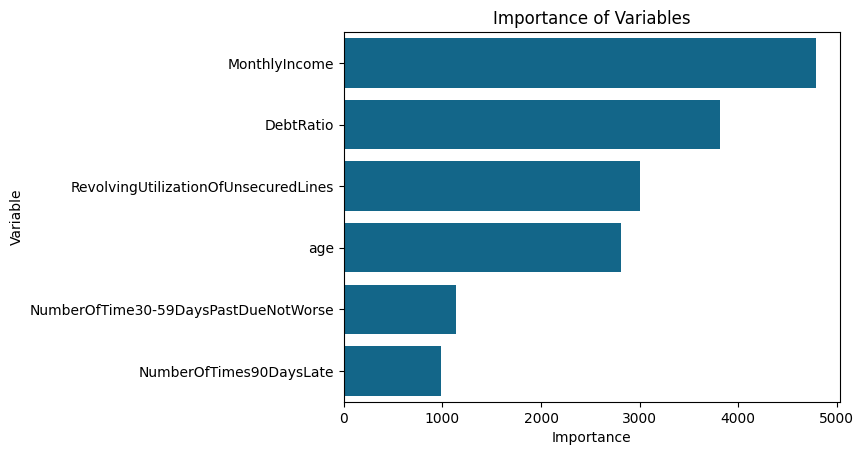

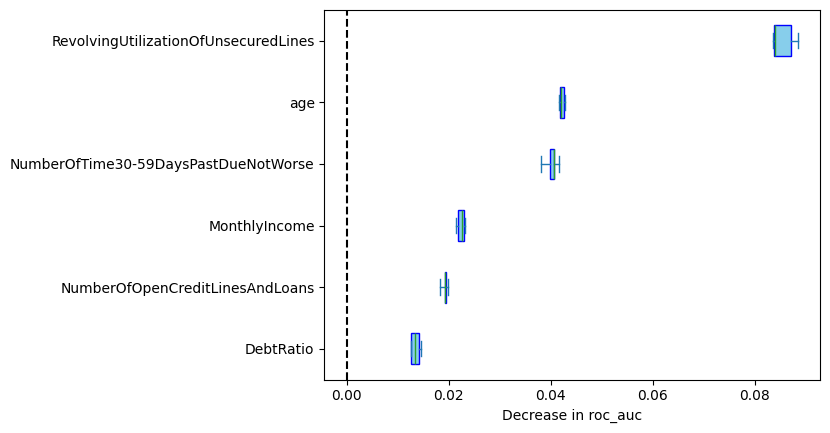

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


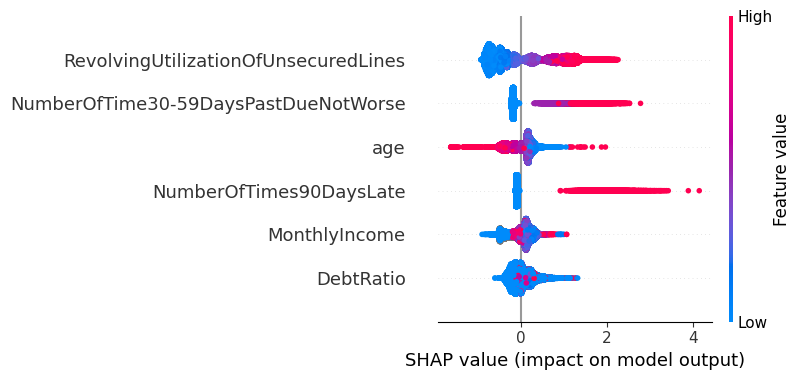

In [18]:
a.get_result_analysis()

In [21]:
acv = AutoMLLGBMClassifierCV(
    X_train, y_train, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc'
)

In [22]:
acv.train()

In [23]:
acv.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   
2  Train CV  0.500000           0.575603   0.587542  0.159243  0.250263   
3      Test  0.206030           0.704950   0.378749  0.464464  0.417250   
4  Train CV  0.500000           0.579835   0.589519  0.168052  0.261411   
5      Test  0.170854           0.726556   0.363517  0.518080  0.427249   

        AUC        KS     Brier               Model  
0  0.861749  0.571792  0.049660          Base Model  
1  0.859473  0.557068  0.049605          Base Model  
2  0.850368  0.554540  0.050558  Best Feature Model  
3  0.850480  0.543173  0.050418  Best Feature Model  
4  0.853282  0.556542  0.050235   Best Params Model  
5  0.852297  0.542445  0.050060   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.861749  0.571792  0.049660  
1  0.859473  0.557068  0.049605

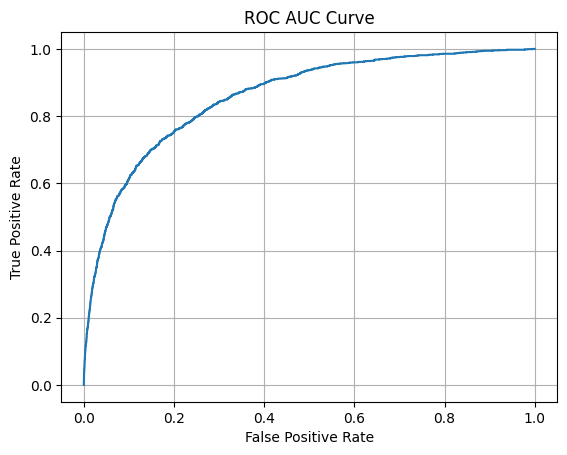

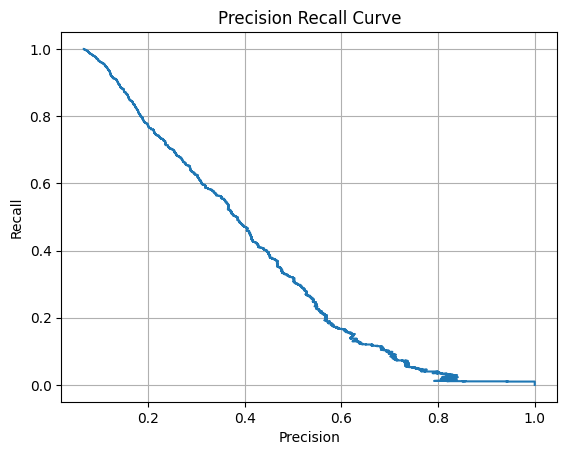

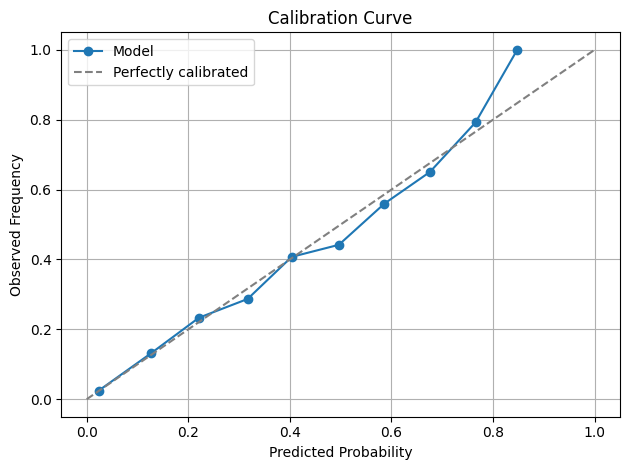

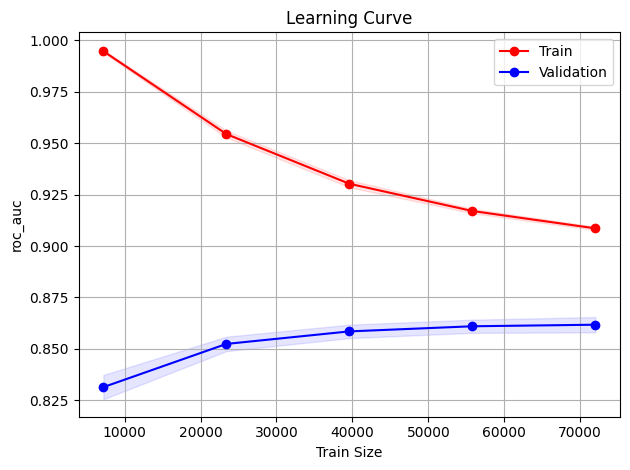

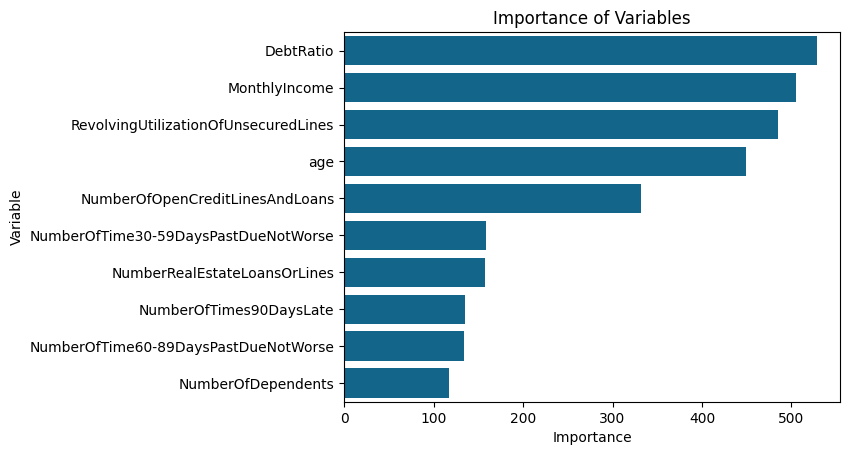

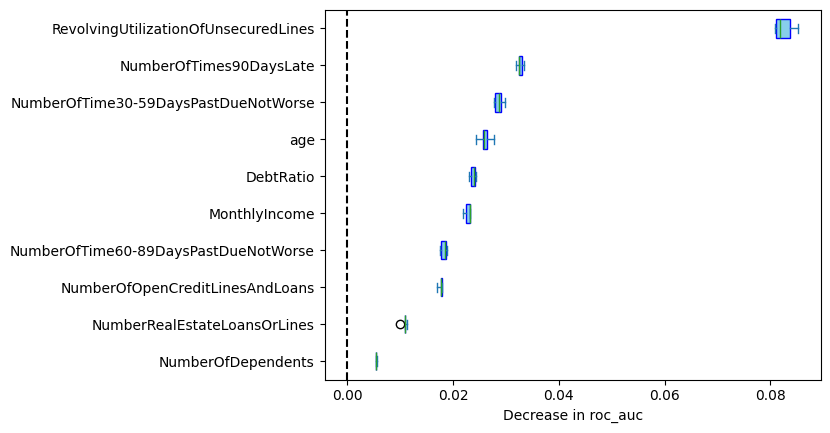

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


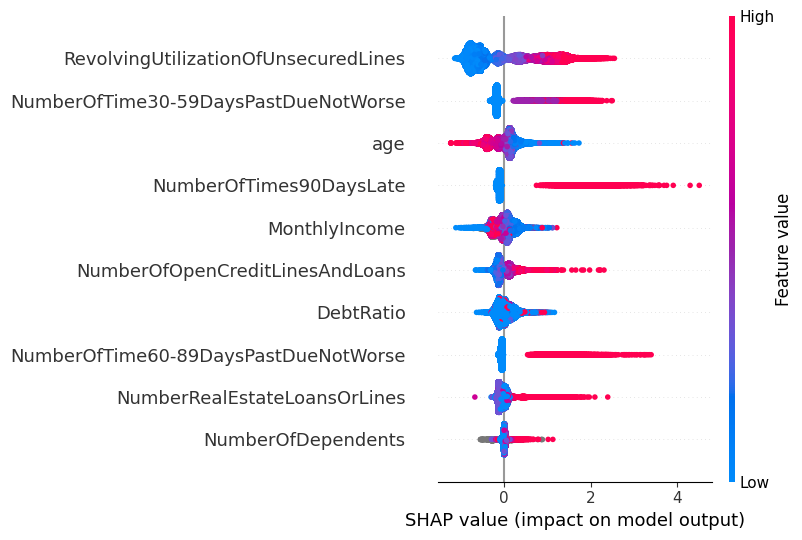

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV   0.50000           0.575603   0.587542  0.159243  0.250263   
1      Test   0.20603           0.704950   0.378749  0.464464  0.417250   

        AUC        KS     Brier  
0  0.850368  0.554540  0.050558  
1  0.850480  0.543173  0.050418

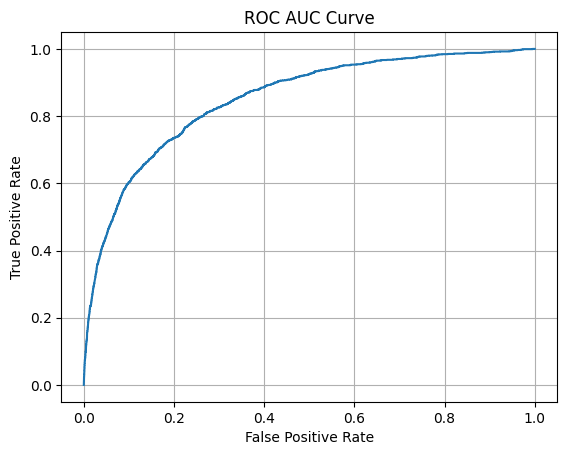

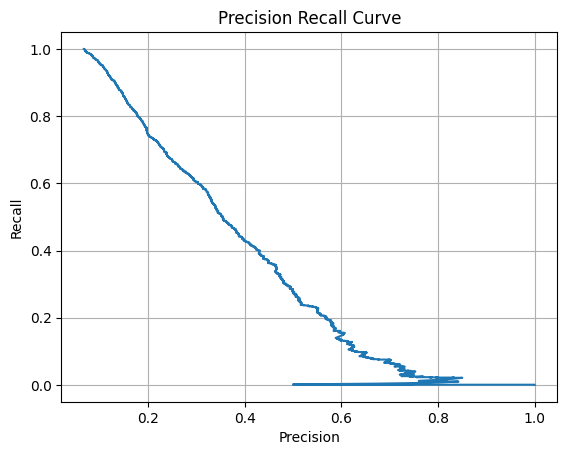

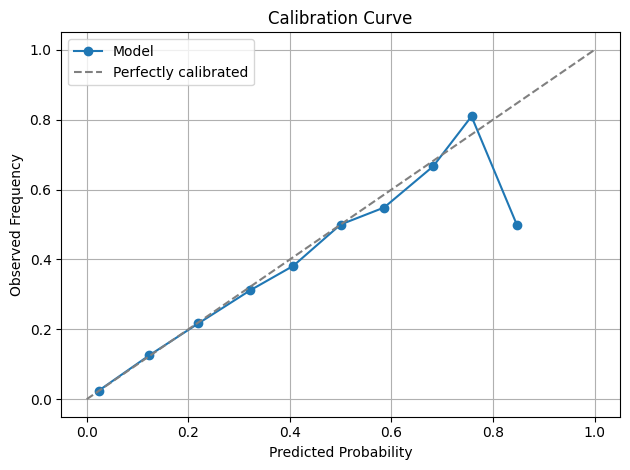

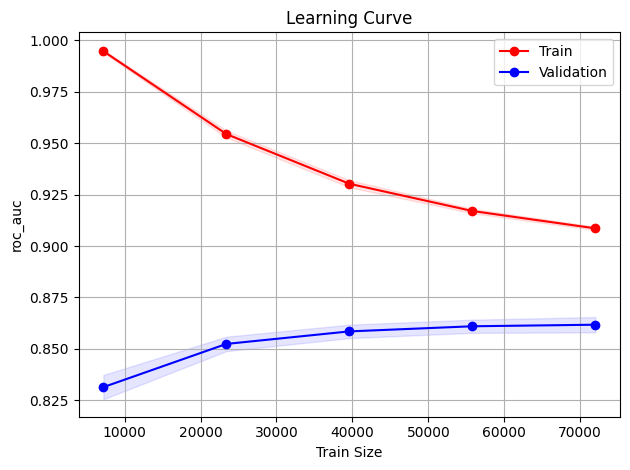

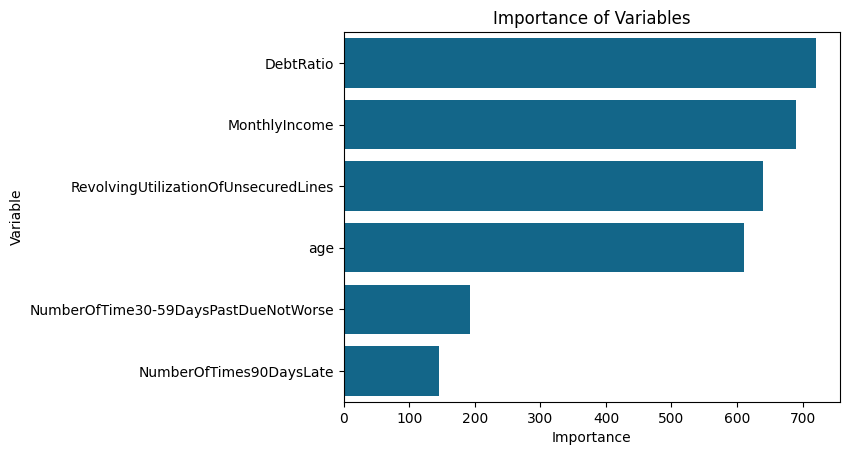

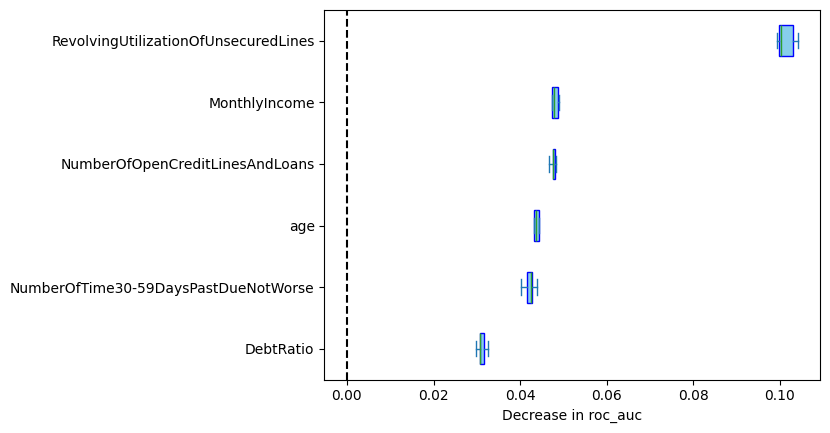

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


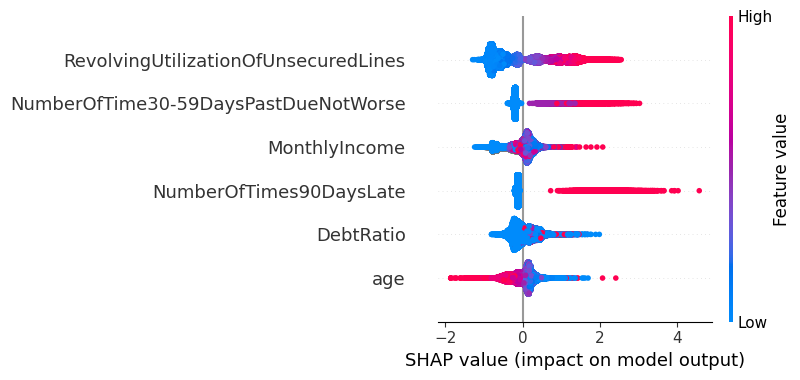

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.579835   0.589519  0.168052  0.261411   
1      Test  0.170854           0.726556   0.363517  0.518080  0.427249   

        AUC        KS     Brier  
0  0.853282  0.556542  0.050235  
1  0.852297  0.542445  0.050060

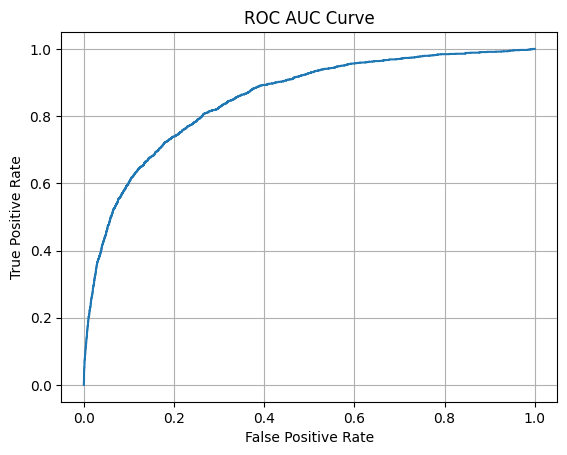

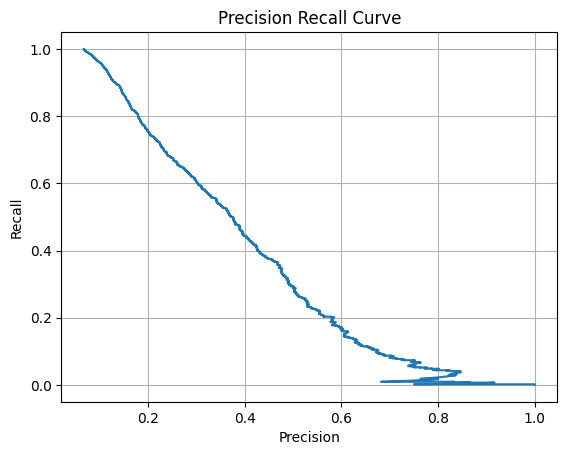

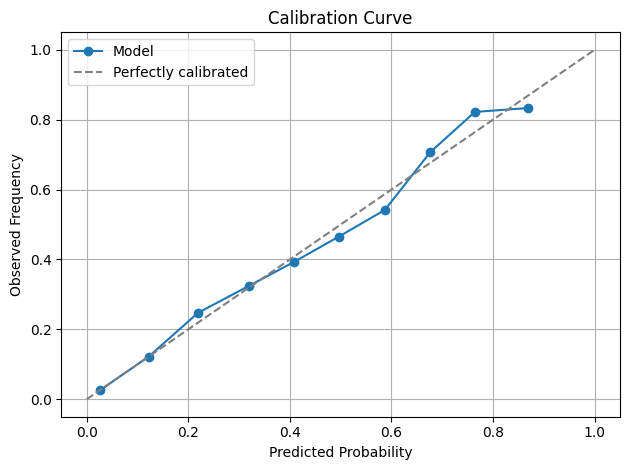

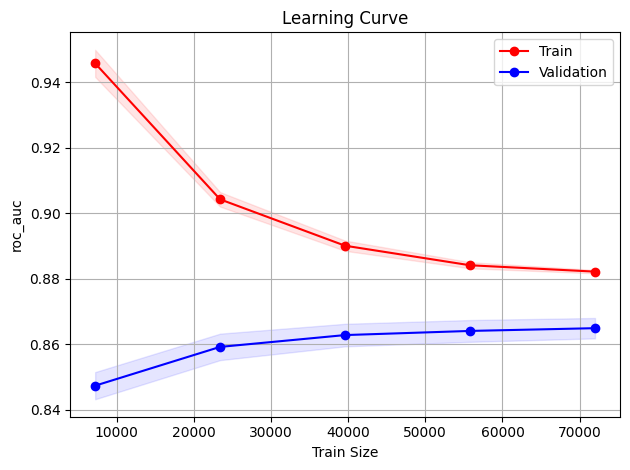

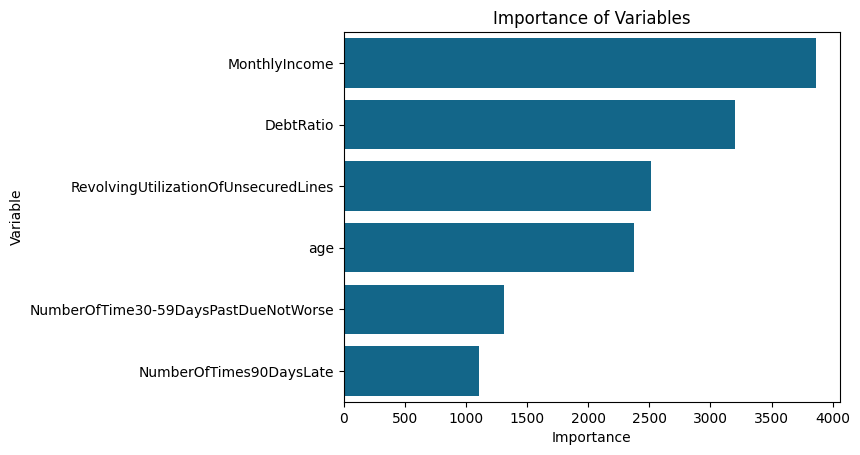

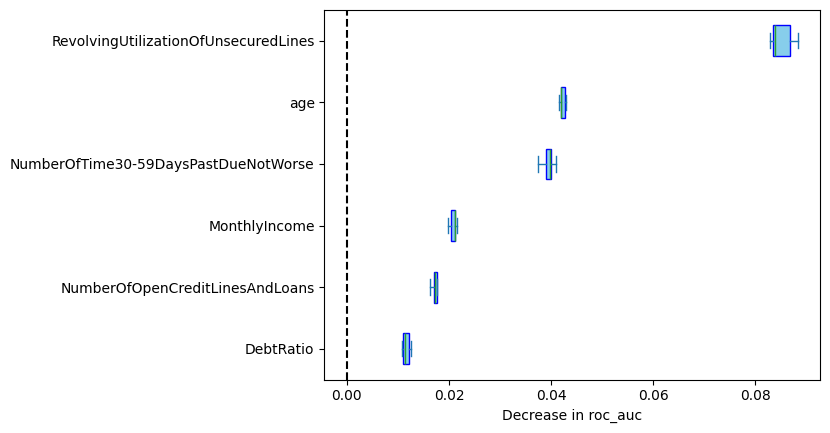

C:\Users\clebio.junior\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


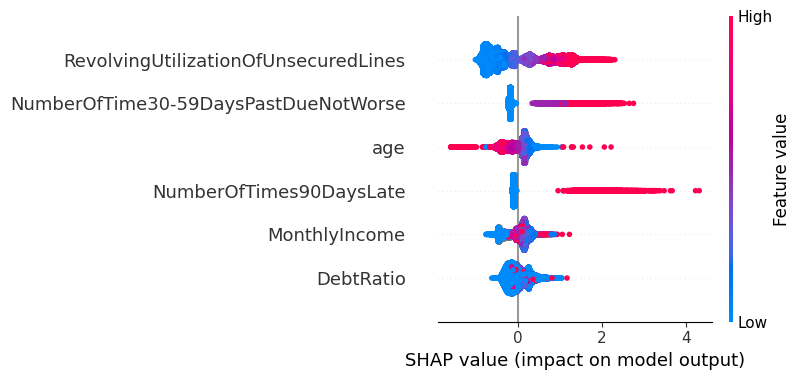

In [24]:
acv.get_result_analysis()

In [25]:
a.best_params_model

LGBMClassifier(colsample_bytree=0.5410982856002644,
               lambda_l1=8.524418159737868e-08, lambda_l2=0.0007601893995100008,
               learning_rate=0.01408593096727302, max_depth=5,
               metric='binary_logloss', min_child_samples=21, n_estimators=600,
               n_jobs=-1, num_leaves=94, objective='binary', random_state=42,
               subsample=0.9521996279090615, verbose=-1)

In [26]:
acv.best_params_model

LGBMClassifier(colsample_bytree=0.552601522554613,
               lambda_l1=8.279035008507772e-05,
               lambda_l2=1.8058286166433588e-07,
               learning_rate=0.012242770869838836, max_depth=4, metric='auc',
               min_child_samples=11, n_estimators=1000, n_jobs=-1,
               num_leaves=39, objective='binary', random_state=42,
               subsample=0.7226223233329659, verbose=-1)